# Applied Machine Learning
Summative Assessment Code
Candidate number: 1080738

## Preliminaries

In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 3.2 MB/s eta 0:00:00


In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=d5b54fd30f1d65dc531dfc980bc0d97eba0cc87829d09288f72117bcaad0eaff
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
## libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import missingno as msno
import seaborn as sns
import time
import shap

from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.metrics import make_scorer, f1_score, accuracy_score
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPRegressor
from lightgbm import LGBMRegressor
from lightgbm import LGBMClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LassoLarsIC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from math import sqrt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator
from lime.lime_tabular import LimeTabularExplainer

from google.colab import drive

In [ ]:
## connecting drive folder
drive.mount('/content/drive')
%cd /content/drive/My Drive/Oxford_SDS_2324

Mounted at /content/drive
/content/drive/My Drive/Oxford_SDS_2324


In [ ]:
## loading data in
background = pd.read_csv ('background.csv')
outcomes = pd.read_csv ('train.csv')
codebook = pd.read_csv ("ffc_variable_types.csv")
holdout = pd.read_csv ("test.csv")

<ipython-input-3-b6e9a2f42c01>:2: DtypeWarning: Columns (10025,10029,10032,10575,10578,10592,10607,10616,10631,10640,10655,10693,10712,10716,10740,10782,10787,10791,10796,10833,10865,10999,11030,11043,11127,11128,11234,11258,11282,11309,11310,11384,11394,11408,11409,11411,11412,11438,11441,11485,11490,11504,11508,11511,11514,11520,11527,11533,11539,11545,11546,11624,11629,11658,11672,11673,11678,11679,11680,11719,11721,11934,12160,12166,12168,12177,12183,12189,12199,12201,12203,12205,12216,12217,12228,12229,12239,12300,12316,12358,12367,12375,12402,12404,12408,12451,12453,12465,12467,12475,12481,12483,12496,12498,12520,12530,12531,12541,12599,12607,12623,12638,12650,12651,12663,12668,12715,12717,12735,12736,12758,12762,12772,12781,12788,12800,12801) have mixed types. Specify dtype option on import or set low_memory=False.
  background = pd.read_csv ('background.csv')


In [ ]:
## checking missingness % for each outcome
percent_missing = outcomes.isnull().sum() * 100 / len(outcomes)
missing_value_df = pd.DataFrame({'column_name': outcomes.columns,
                                 'percent_missing': percent_missing})
display (missing_value_df)

,column_name,percent_missing
challengeID,challengeID,0.000000
gpa,gpa,45.073079
grit,grit,33.144743
materialHardship,materialHardship,31.211693
eviction,eviction,31.211693
layoff,layoff,39.792551
jobTraining,jobTraining,31.117397


## Baseline Models

### Data cleaning

In [ ]:
## converting selected columns to categorical
cols_to_convert = ['eviction', 'layoff', 'jobTraining']
outcomes[cols_to_convert] = outcomes[cols_to_convert].astype('category')

# verify the changes
print (f"unique value in eviction: {outcomes['eviction'].unique()}",
       f"unique value in layoff: {outcomes['layoff'].unique()}",
       f"unique value in jobTraining: {outcomes['jobTraining'].unique()}")

unique value in eviction: [NaN, 0.0, 1.0]
Categories (2, float64): [0.0, 1.0] unique value in layoff: [NaN, 0.0, 1.0]
Categories (2, float64): [0.0, 1.0] unique value in jobTraining: [NaN, 0.0, 1.0]
Categories (2, float64): [0.0, 1.0]


In [ ]:
## keeping only constructed vars
codebook_nona = codebook.dropna (subset=['label'])
vars_constructed = codebook_nona [codebook_nona['label'].str.contains('Constructed')]
vars_constructed = vars_constructed ['variable'].tolist()
cols_keep = ['challengeID'] + vars_constructed
background_cons = background [cols_keep]
background_cons2 = background_cons.copy()

## removing unknown vartype columns
unknown_variables = codebook[codebook['variable_type'] == 'unknown']['variable'].tolist()
unknown_cons_vars = list(set(vars_constructed).intersection(unknown_variables))
background_cons2 = background_cons2.drop (columns = unknown_cons_vars)

In [ ]:
background_cons2.shape

(4242, 273)

In [ ]:
## getting proportion of NaNs or negative values
def percent_invalid_values(df):
    total_rows = len(df)
    invalid_counts = {}

    for column in df.columns:

        # Skip non-numeric columns
        if np.issubdtype(df[column].dtype, np.number):
            # Count NaNs and negative values
            nan_count = df[column].isna().sum()
            negative_count = (df[column] < 0).sum()
            total_invalid = nan_count + negative_count

            # Calculate percentage
            percent_invalid = (total_invalid / total_rows) * 100

            # Store result
            invalid_counts[column] = percent_invalid

    return invalid_counts

## applying function
invalid_percentages = percent_invalid_values(background_cons2)
print(invalid_percentages)

{'challengeID': 0.0, 'cm1fint': 0.023573785950023574, 'cm1citsm': 0.0, 'cm1age': 0.1885902876001886, 'cm1bsex': 0.023573785950023574, 'cm1lbw': 3.8425271098538425, 'cm1numb': 0.023573785950023574, 'cm1relf': 0.04714757190004715, 'cm1marf': 0.023573785950023574, 'cm1cohf': 0.04714757190004715, 'cm1adult': 0.4479019330504479, 'cm1kids': 0.4479019330504479, 'cm1gdad': 0.49504950495049505, 'cm1gmom': 0.4714757190004715, 'cm1hhinc': 0.023573785950023574, 'cm1hhimp': 0.023573785950023574, 'cm1inpov': 0.023573785950023574, 'cm1povca': 0.023573785950023574, 'cm1span': 0.5893446487505893, 'cf1twoc': 22.065063649222065, 'cf1fint': 0.0, 'cf1age': 42.29137199434229, 'cf1marm': 22.065063649222065, 'cf1cohm': 22.065063649222065, 'cf1adult': 23.40876944837341, 'cf1kids': 23.385195662423385, 'cf1gdad': 23.385195662423385, 'cf1gmom': 23.385195662423385, 'cf1hhinc': 22.065063649222065, 'cf1hhimp': 22.065063649222065, 'cf1inpov': 22.065063649222065, 'cf1povca': 22.065063649222065, 'cf1tele': 22.512965582

Percentage of columns with y-axis = 0: 6.25%


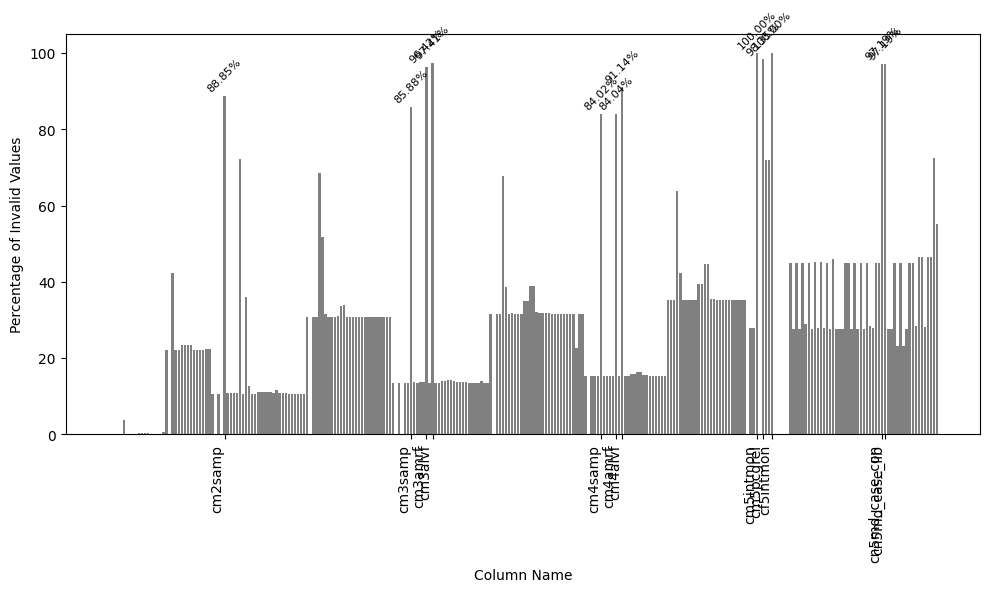

In [ ]:
## plotting
plt.figure (figsize = (10, 6))
bars = plt.bar (invalid_percentages.keys(), invalid_percentages.values(), color = 'gray')

## adding labels for columns with percentage > 80
for bar, (column, percentage) in zip (bars, invalid_percentages.items()):
    if percentage > 80:
        plt.text(bar.get_x() + bar.get_width() / 2,
                 bar.get_height() + 0.5,
                 f'{percentage:.2f}%',
                 ha='center',
                 va='bottom',
                 rotation = 45,
                 fontsize = 8)

## calculating the percentage of columns with y-axis = 0
zero_height_columns = sum (1 for bar in bars if bar.get_height() == 0)
total_columns = len (invalid_percentages)
percent_zero_height = (zero_height_columns / total_columns) * 100
print(f"Percentage of columns with y-axis = 0: {percent_zero_height:.2f}%")

## setting x-axis ticks only for labeled columns
plt.xticks ([column for column, percentage in invalid_percentages.items() if percentage > 80], rotation=90, ha='right')
plt.xlabel ('Column Name')
plt.ylabel ('Percentage of Invalid Values')
plt.tight_layout()
plt.show()

IndexError: index 2 is out of bounds for axis 0 with size 2

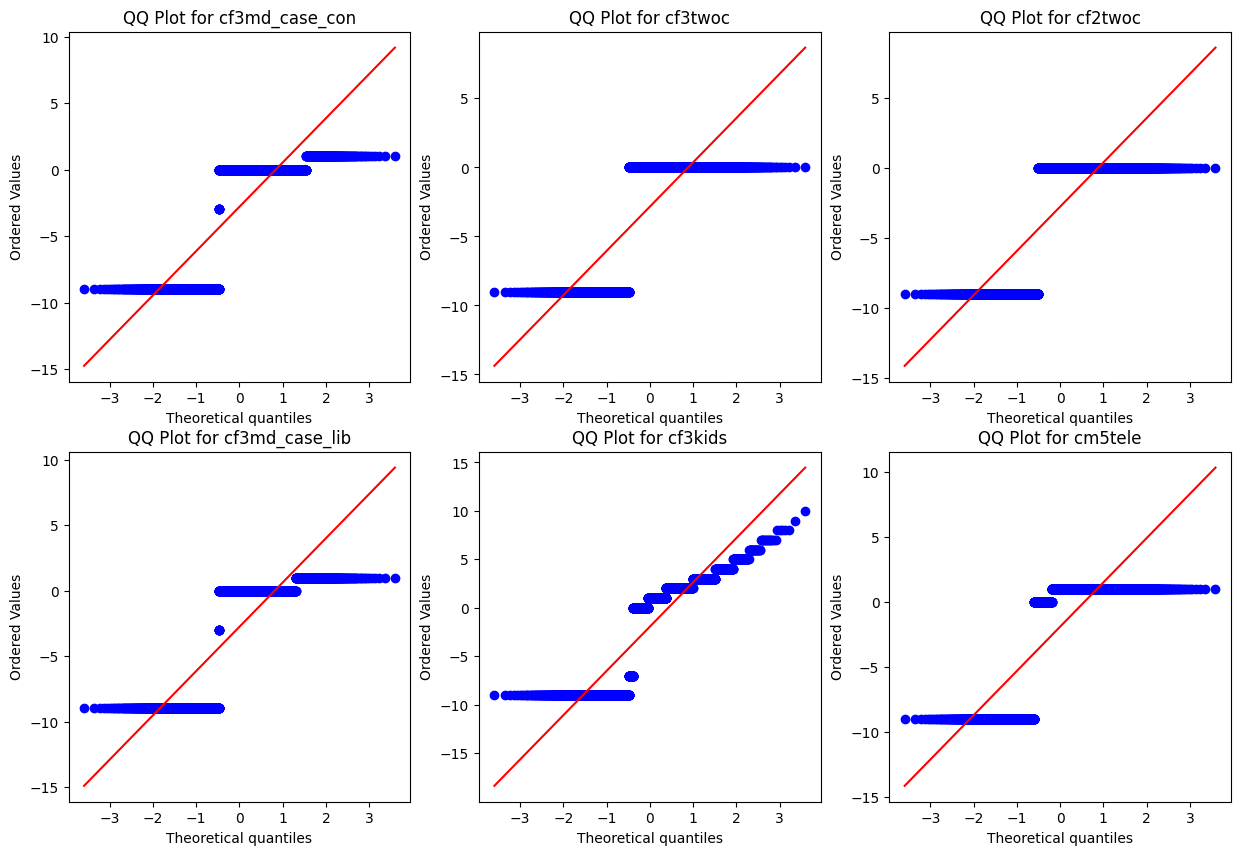

In [ ]:
## showing that the data is non-normally distributed

## selecting a random subset of 10 columns
random_columns = np.random.choice (background_cons2.columns, size=9, replace=False)
df_subset = background_cons2[random_columns].copy()

## grid of QQ plots for the selected columns
num_plots = len(random_columns)
num_rows = num_plots // 2 + num_plots % 2
fig, axes = plt.subplots (2, 3, figsize=(15, 10))

for i, column in enumerate (random_columns):
    row = i // 3
    col = i % 3
    ax = axes[row, col]

    ## making QQ plot for the column
    stats.probplot (df_subset[column], dist = "norm", plot = ax)
    ax.set_title (f'QQ Plot for {column}')
    ax.set_xlabel ('Theoretical quantiles')
    ax.set_ylabel ('Ordered Values')

# Remove any empty subplot
if len(random_columns) < 6:
    for i in range(len(random_columns), 6):
        fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

In [ ]:
## converting all negative values to NaNs in background
background2 = background_cons2.copy()
background2 = background2.drop (columns = ['cf4fint'])
background2 = background2.applymap (lambda x: np.nan if x < 0 else x)

In [ ]:
## removing variables with more than 80% missingness and too low variance
def remove_too_many_nans (df, threshold = 0.8):

    # getting column-specific NaN proportions
    missing_value_proportion = df.isnull().mean()

    # identifying those with 80%+ missingness
    selected_columns = missing_value_proportion [missing_value_proportion < threshold].index

    # removing selected cols
    df_filtered = df[selected_columns]
    return df_filtered

## removing variables with too low variance
def remove_too_low_variance (df, threshold = 0.05):

    # isolate numerical columns
    numerical_columns = df.select_dtypes (include = ['number']).columns

    # compute variance for each column
    column_variances = df[numerical_columns].var()

    # choosing columns where absolute variance is above the threshold
    selected_columns = column_variances [column_variances >= threshold].index

    # removing selected cols
    df_filtered = df[selected_columns]
    return df_filtered

## applying functions
background3 = remove_too_many_nans (background2)
background4 = remove_too_low_variance (background3)

## result
print (f"Before cleaning, my df had {background2.shape[1]} columns. Now it has {background4.shape[1]} columns!")

Before cleaning, my df had 272 columns. Now it has 211 columns!


In [ ]:
## data cleaning function
def datClean (codebook, x, y, varname, split = True):

  # isolating var in y
  y = y[['challengeID', varname]]

  # x vartypes
  categorical_variables = codebook[codebook['variable_type'] == 'categorical']['variable'].tolist()
  continuous_variables = codebook[codebook['variable_type'] == 'continuous']['variable'].tolist()

  # imputer function
  def conditional_impute (x, list1, list2):

    # creating copy of df
    x2 = x.copy()

    # imputers
    mean_imputer = SimpleImputer (strategy = 'mean')
    mode_imputer = SimpleImputer (strategy = 'most_frequent')

    # impute variables in continuous_variables with mean
    for col in list1:
        if col in x.columns:
            x2.loc[:, col] = mean_imputer.fit_transform (x2[[col]])

    # impute variables in categorical_variables with mode
    for col in list2:
        if col in x.columns:
            x2.loc[:, col] = mode_imputer.fit_transform (x2[[col]])

    return x2

  # applying function
  x_imp = conditional_impute (x, continuous_variables, categorical_variables)
  x_imp = x_imp.select_dtypes(exclude = ['object'])

  # creating main data frame
  master_df = x_imp.merge (y, on = "challengeID")

  # keeping only rows with no NaNs in varname
  master_df = master_df.dropna (subset = [varname])

  # upsampling for categorical bars
  outcome_vars_cont = ['gpa', 'grit', 'materialHardship']
  outcome_vars_cat = ['eviction', 'layoff', 'jobTraining']

  # upsampling if varname belongs to outcome_vars_cat
  if varname in outcome_vars_cat:

    # determining majority and minority classes
    class_counts = master_df[varname].value_counts()
    majority_class = class_counts.idxmax()
    minority_class = class_counts.idxmin()

    # separating majority and minority classes
    df_majority = master_df [master_df[varname] == majority_class]
    df_minority = master_df [master_df[varname] == minority_class]

    # Upsample minority class
    df_minority_upsampled = resample (df_minority,
                                      replace = True,
                                      n_samples = len(df_majority),
                                      random_state = 13)

    # Combine majority class with upsampled minority class
    master_df = pd.concat ([df_majority, df_minority_upsampled])

  # splitting
  if split:

    # splitting into test and train and then x and y
    train, test = train_test_split (master_df, test_size = 0.3, random_state = 13)
    train_x, train_y = train.iloc[:, :-1], train.iloc[:, -1]
    test_x, test_y = test.iloc[:, :-1], test.iloc[:, -1]

    return train_x, train_y, test_x, test_y

  else:

    # splitting masterdf
    dat_x, dat_y = master_df.iloc[:, :-1], master_df.iloc[:, -1]

    return dat_x, dat_y

### Running models

In [ ]:
## categorising outcomes
outcome_vars_cont = ['gpa', 'grit', 'materialHardship']
outcome_vars_cat = ['eviction', 'layoff', 'jobTraining']

#### Linear

In [ ]:
## initialising storage object
results_lin_cont = []

## executing model
for var in outcome_vars_cont:

    # getting data
    dat_x, dat_y = datClean (codebook, background4, outcomes, var, split = False)

    # fitting the model
    model = LinearRegression()

    # computing MSE and RMSE through 5-fold cross validation
    mse_scores = -cross_val_score (model, dat_x, dat_y, cv = 5, scoring = 'neg_mean_squared_error')
    rmse_scores = np.sqrt(mse_scores)

    # appending the mean of the results
    results_lin_cont.append([var, mse_scores.mean(), rmse_scores.mean()])

## converting the results to a DataFrame
results_df_lin_cont = pd.DataFrame (results_lin_cont, columns = ['variable', 'MSE', 'RMSE'])
results_df_lin_cont['model'] = 'OLS'
display (results_df_lin_cont)

,variable,MSE,RMSE,model
0,gpa,0.516309,0.717608,OLS
1,grit,0.283923,0.532277,OLS
2,materialHardship,0.027377,0.165129,OLS


In [ ]:
## initialising storage object
results_lin_cat = []

# Loop over each outcome variable
for var in outcome_vars_cat:

    ## getting data
    dat_x, dat_y = datClean (codebook, background4, outcomes, var, split = False)

    # fitting the model
    model = LogisticRegression()

    # computing accuracy and F1 scores using 5-fold CV
    accuracy_scores = cross_val_score (model, dat_x, dat_y, cv = 5, scoring = make_scorer (accuracy_score))
    f1_scores = cross_val_score (model, dat_x, dat_y, cv = 5, scoring = make_scorer (f1_score, average = 'weighted'))

    # Append the results
    results_lin_cat.append([var, accuracy_scores.mean(), f1_scores.mean()])

# Convert the results to a DataFrame
results_df_lin_cat = pd.DataFrame (results_lin_cat, columns=['variable', 'Accuracy', 'F1'])
results_df_lin_cat['model'] = 'Logistic Regression'
display (results_df_lin_cat)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

,variable,Accuracy,F1,model
0,eviction,0.583835,0.571099,Logistic Regression
1,layoff,0.461386,0.440247,Logistic Regression
2,jobTraining,0.447731,0.428981,Logistic Regression


#### Regularised Linear

In [ ]:
## initialising storage object
results_enet_cont = []

## executing model
for var in outcome_vars_cont:

    # getting data
    dat_x, dat_y = datClean (codebook, background4, outcomes, var, split = False)

    # fitting the model
    model = ElasticNet()

    # computing MSE and RMSE through 5-fold cross validation
    mse_scores = -cross_val_score (model, dat_x, dat_y, cv = 5, scoring = 'neg_mean_squared_error')
    rmse_scores = np.sqrt(mse_scores)

    # appending the mean of the results
    results_enet_cont.append([var, mse_scores.mean(), rmse_scores.mean()])

## converting the results to a DataFrame
results_df_enet_cont = pd.DataFrame (results_enet_cont, columns = ['variable', 'MSE', 'RMSE'])
results_df_enet_cont['model'] = 'ElasticNet'
display (results_df_enet_cont)

,variable,MSE,RMSE,model
0,gpa,0.406696,0.637363,ElasticNet
1,grit,0.234083,0.483774,ElasticNet
2,materialHardship,0.022843,0.150957,ElasticNet


In [ ]:
## initialising storage object
results_reg_cat = []

# Loop over each outcome variable
for var in outcome_vars_cat:

    ## getting data
    dat_x, dat_y = datClean (codebook, background4, outcomes, var, split = False)

    # fitting the model
    model = RidgeClassifier ()

    # computing accuracy and F1 scores using 5-fold CV
    accuracy_scores = cross_val_score (model, dat_x, dat_y, cv = 5, scoring = make_scorer (accuracy_score))
    f1_scores = cross_val_score (model, dat_x, dat_y, cv = 5, scoring = make_scorer (f1_score, average = 'weighted'))

    # Append the results
    results_reg_cat.append([var, accuracy_scores.mean(), f1_scores.mean()])

# Convert the results to a DataFrame
results_df_reg_cat = pd.DataFrame (results_reg_cat, columns=['variable', 'Accuracy', 'F1'])
results_df_reg_cat['model'] = 'Ridge Logistic Regression'
display (results_df_reg_cat)

,variable,Accuracy,F1,model
0,eviction,0.834195,0.830234,Ridge Logistic Regression
1,layoff,0.620297,0.613816,Ridge Logistic Regression
2,jobTraining,0.590799,0.584513,Ridge Logistic Regression


#### Decision Tree

In [ ]:
## initialising storage object
results_tree_cont = []

## executing model
for var in outcome_vars_cont:

    # getting data
    dat_x, dat_y = datClean (codebook, background4, outcomes, var, split = False)

    # fitting the model
    model = DecisionTreeRegressor()

    # computing MSE and RMSE through 5-fold cross validation
    mse_scores = -cross_val_score (model, dat_x, dat_y, cv = 5, scoring = 'neg_mean_squared_error')
    rmse_scores = np.sqrt(mse_scores)

    # appending the mean of the results
    results_tree_cont.append([var, mse_scores.mean(), rmse_scores.mean()])

## converting the results to a DataFrame
results_df_tree_cont = pd.DataFrame (results_tree_cont, columns = ['variable', 'MSE', 'RMSE'])
results_df_tree_cont['model'] = 'DecisionTree'
display (results_df_tree_cont)

,variable,MSE,RMSE,model
0,gpa,0.831760,0.911480,DecisionTree
1,grit,0.480158,0.692509,DecisionTree
2,materialHardship,0.045521,0.213245,DecisionTree


In [ ]:
## initialising storage object
results_tree_cat = []

# Loop over each outcome variable
for var in outcome_vars_cat:

    ## getting data
    dat_x, dat_y = datClean (codebook, background4, outcomes, var, split = False)

    # fitting the model
    model = DecisionTreeClassifier()

    # computing accuracy and F1 scores using 5-fold CV
    accuracy_scores = cross_val_score (model, dat_x, dat_y, cv = 5, scoring = make_scorer (accuracy_score))
    f1_scores = cross_val_score (model, dat_x, dat_y, cv = 5, scoring = make_scorer (f1_score, average = 'weighted'))

    # Append the results
    results_tree_cat.append([var, accuracy_scores.mean(), f1_scores.mean()])

# Convert the results to a DataFrame
results_df_tree_cat = pd.DataFrame (results_tree_cat, columns=['variable', 'Accuracy', 'F1'])
results_df_tree_cat['model'] = 'Decision Tree'
display (results_df_tree_cat)

,variable,Accuracy,F1,model
0,eviction,0.740905,0.682393,Decision Tree
1,layoff,0.588119,0.478366,Decision Tree
2,jobTraining,0.505371,0.375882,Decision Tree


#### Random Forest

In [ ]:
## initialising storage object
results_rf_cont = []

## executing model
for var in outcome_vars_cont:

    # getting data
    dat_x, dat_y = datClean (codebook, background4, outcomes, var, split = False)

    # fitting the model
    model = RandomForestRegressor()

    # computing MSE and RMSE through 5-fold cross validation
    mse_scores = -cross_val_score (model, dat_x, dat_y, cv = 5, scoring = 'neg_mean_squared_error')
    rmse_scores = np.sqrt(mse_scores)

    # appending the mean of the results
    results_rf_cont.append([var, mse_scores.mean(), rmse_scores.mean()])

## converting the results to a DataFrame
results_df_rf_cont = pd.DataFrame (results_rf_cont, columns = ['variable', 'MSE', 'RMSE'])
results_df_rf_cont['model'] = 'RandomForest'
display (results_df_rf_cont)

,variable,MSE,RMSE,model
0,gpa,0.405152,0.636131,RandomForest
1,grit,0.235771,0.485484,RandomForest
2,materialHardship,0.023513,0.153181,RandomForest


In [ ]:
## initialising storage object
results_rf_cat = []

# Loop over each outcome variable
for var in outcome_vars_cat:

    ## getting data
    dat_x, dat_y = datClean (codebook, background4, outcomes, var, split = False)

    # fitting the model
    model = RandomForestClassifier()

    # computing accuracy and F1 scores using 5-fold CV
    accuracy_scores = cross_val_score (model, dat_x, dat_y, cv = 5, scoring = make_scorer (accuracy_score))
    f1_scores = cross_val_score (model, dat_x, dat_y, cv = 5, scoring = make_scorer (f1_score, average = 'weighted'))

    # Append the results
    results_rf_cat.append([var, accuracy_scores.mean(), f1_scores.mean()])

# Convert the results to a DataFrame
results_df_rf_cat = pd.DataFrame (results_rf_cat, columns=['variable', 'Accuracy', 'F1'])
results_df_rf_cat['model'] = 'Random Forest'
display (results_df_rf_cat)

,variable,Accuracy,F1,model
0,eviction,1.000000,0.999270,Random Forest
1,layoff,0.824257,0.809864,Random Forest
2,jobTraining,0.747410,0.737015,Random Forest


#### Gradient Boosting

In [ ]:
## initialising storage object
results_gb_cont = []

## executing model
for var in outcome_vars_cont:

    # getting data
    dat_x, dat_y = datClean (codebook, background4, outcomes, var, split = False)

    # fitting the model
    model = GradientBoostingRegressor()

    # computing MSE and RMSE through 5-fold cross validation
    mse_scores = -cross_val_score (model, dat_x, dat_y, cv = 5, scoring = 'neg_mean_squared_error')
    rmse_scores = np.sqrt(mse_scores)

    # appending the mean of the results
    results_gb_cont.append([var, mse_scores.mean(), rmse_scores.mean()])

## converting the results to a DataFrame
results_df_gb_cont = pd.DataFrame (results_gb_cont, columns = ['variable', 'MSE', 'RMSE'])
results_df_gb_cont['model'] = 'Gradient Boosting'
display (results_df_gb_cont)

,variable,MSE,RMSE,model
0,gpa,0.424787,0.651276,Gradient Boosting
1,grit,0.244756,0.494598,Gradient Boosting
2,materialHardship,0.024251,0.155552,Gradient Boosting


In [ ]:
## initialising storage object
results_gb_cat = []

# Loop over each outcome variable
for var in outcome_vars_cat:

    ## getting data
    dat_x, dat_y = datClean (codebook, background4, outcomes, var, split = False)

    # fitting the model
    model = GradientBoostingClassifier()

    # computing accuracy and F1 scores using 5-fold CV
    accuracy_scores = cross_val_score (model, dat_x, dat_y, cv = 5, scoring = make_scorer (accuracy_score))
    f1_scores = cross_val_score (model, dat_x, dat_y, cv = 5, scoring = make_scorer (f1_score, average = 'weighted'))

    # Append the results
    results_gb_cat.append([var, accuracy_scores.mean(), f1_scores.mean()])

# Convert the results to a DataFrame
results_df_gb_cat = pd.DataFrame (results_gb_cat, columns=['variable', 'Accuracy', 'F1'])
results_df_gb_cat['model'] = 'Gradient Boosting'
display (results_df_gb_cat)

,variable,Accuracy,F1,model
0,eviction,0.705169,0.657223,Gradient Boosting
1,layoff,0.467327,0.362610,Gradient Boosting
2,jobTraining,0.425315,0.324219,Gradient Boosting


In [ ]:
from lightgbm import LGBMClassifier

## initialising storage object
results_lgbm_cont = []

## executing model
for var in outcome_vars_cont:

    # getting data
    dat_x, dat_y = datClean (codebook, background4, outcomes, var, split = False)

    # fitting the model
    model = LGBMRegressor()

    # computing MSE and RMSE through 5-fold cross validation
    mse_scores = -cross_val_score (model, dat_x, dat_y, cv = 5, scoring = 'neg_mean_squared_error')
    rmse_scores = np.sqrt(mse_scores)

    # appending the mean of the results
    results_lgbm_cont.append([var, mse_scores.mean(), rmse_scores.mean()])

## converting the results to a DataFrame
results_df_lgbm_cont = pd.DataFrame (results_lgbm_cont, columns = ['variable', 'MSE', 'RMSE'])
results_df_lgbm_cont['model'] = 'LGBM'
display (results_df_lgbm_cont)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002199 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8749
[LightGBM] [Info] Number of data points in the train set: 932, number of used features: 209
[LightGBM] [Info] Start training from score 2.860247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001952 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8748
[LightGBM] [Info] Number of data points in the train set: 932, number of used features: 209
[LightGBM] [Info] Start training from score 2.862929
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001652 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

,variable,MSE,RMSE,model
0,gpa,0.430200,0.655291,LGBM
1,grit,0.256216,0.505877,LGBM
2,materialHardship,0.024815,0.157361,LGBM


In [ ]:
## initialising storage object
results_lgbm_cat = []

# Loop over each outcome variable
for var in outcome_vars_cat:

    ## getting data
    dat_x, dat_y = datClean (codebook, background4, outcomes, var, split = False)

    # fitting the model
    model = LGBMClassifier()

    # computing accuracy and F1 scores using 5-fold CV
    accuracy_scores = cross_val_score (model, dat_x, dat_y, cv = 5, scoring = make_scorer (accuracy_score))
    f1_scores = cross_val_score (model, dat_x, dat_y, cv = 5, scoring = make_scorer (f1_score, average = 'weighted'))

    # Append the results
    results_lgbm_cat.append([var, accuracy_scores.mean(), f1_scores.mean()])

# Convert the results to a DataFrame
results_df_lgbm_cat = pd.DataFrame (results_lgbm_cat, columns=['variable', 'Accuracy', 'F1'])
results_df_lgbm_cat['model'] = 'Gradient Boosting'
display (results_df_lgbm_cat)

[LightGBM] [Info] Number of positive: 1098, number of negative: 1097
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003719 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8816
[LightGBM] [Info] Number of data points in the train set: 2195, number of used features: 210
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500228 -> initscore=0.000911
[LightGBM] [Info] Start training from score 0.000911
[LightGBM] [Info] Number of positive: 1098, number of negative: 1097
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003329 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8808
[LightGBM] [Info] Number of data points in the train set: 2195, number of used features: 210
[LightGBM] [Info] [binar

,variable,Accuracy,F1,model
0,eviction,0.688713,0.600789,Gradient Boosting
1,layoff,0.523267,0.396978,Gradient Boosting
2,jobTraining,0.481218,0.345751,Gradient Boosting


## Predictive model on GPA

### Data cleaning

In [ ]:
## adding additional GPA-related vars to background df
background5 = background4.copy()

## variables relating to education
pattern = 'school|educ|School|Educ|grade|Grade|class|Class'
vars_edu = codebook_nona [codebook_nona['label'].str.contains(pattern)]
vars_edu = vars_edu ['variable'].tolist()
df_vars_edu = background [background.columns.intersection (vars_edu)].copy()

## cognitive score variables
vars_scores = [
    'cm3cogsc',
    'cf3cogsc',
    'hv5_dsss',
    'hv5_ppvtss',
    'hv5_wj9ss',
    'hv5_wj10ss',
    'hv5_bmiz',
    'hv5_waz',
    'hv5_haz',
    'hv5_mbmiz'
]
df_vars_scores = background [background.columns.intersection (vars_scores)].copy()

## concatenating
background5 = pd.concat ([background5[['challengeID']],
                          background['n5e3'],
                          df_vars_edu,
                          df_vars_scores],
                         axis = 1)

In [ ]:
## running data cleaning functions for variance and NaNs
background6 = remove_too_many_nans (background5, threshold = 0.6)
background7 = remove_too_low_variance (background6)

In [ ]:
## turning negative values into NaNs
background8 = background7.applymap(lambda x: np.nan if x < 0 else x)

In [ ]:
background8.shape

(4242, 670)

In [ ]:
## creating a copy of the original dataframe
background8_imputed_df = background8.copy()

## creating imputers
mean_imputer = SimpleImputer(strategy='mean')
mode_imputer = SimpleImputer(strategy='most_frequent')

## col objects
categorical_variables = codebook[codebook['variable_type'] == 'categorical']['variable'].tolist()
continuous_variables = codebook[codebook['variable_type'] == 'continuous']['variable'].tolist()
continuous_cols = [col for col in continuous_variables if col in background7.columns]
categorical_cols = [col for col in categorical_variables if col in background7.columns]
other_cols = [col for col in background7.columns if col not in categorical_variables and col not in continuous_variables]

for col in background8.columns:

    if col in continuous_cols:

        # Mean imputation
        background8_imputed_df[col] = mean_imputer.fit_transform(background8[[col]])

    elif col in other_cols or col in categorical_cols:

        # Mode imputation
        background8_imputed_df[col] = mode_imputer.fit_transform (background8[[col]])

## displaying sample of final df
display (background8_imputed_df.sample (10))

,challengeID,n5e3,cm1edu,m1i1,m1i3,m1i6,cf1edu,f1i1,m2b35a,m2b35b,...,cm3cogsc,cf3cogsc,hv5_dsss,hv5_ppvtss,hv5_wj9ss,hv5_wj10ss,hv5_waz,hv5_bmiz,hv5_haz,hv5_mbmiz
1038,1039,42146.419243,2.0,4.0,4.0,1.0,2.0,3.0,1.305361,2.0,...,6.000000,7.000000,6.000000,75.000000,57.00000,64.000000,0.449083,0.471571,0.908724,0.022901
3202,3203,42146.419243,2.0,4.0,4.0,1.0,2.0,4.0,1.305361,2.0,...,0.000000,6.563509,9.422882,92.985709,93.11373,97.965986,1.315369,1.266076,1.020845,0.948661
2537,2538,42146.419243,2.0,4.0,4.0,1.0,2.0,4.0,1.305361,2.0,...,8.000000,3.000000,7.000000,79.000000,89.00000,84.000000,1.961439,2.302462,1.020845,0.948661
542,543,42146.419243,4.0,9.0,9.0,1.0,4.0,3.0,1.305361,2.0,...,6.845522,6.563509,9.422882,92.985709,93.11373,97.965986,1.315369,1.266076,1.020845,0.948661
2303,2304,42146.419243,2.0,4.0,7.0,1.0,3.0,4.0,1.305361,2.0,...,6.000000,5.000000,9.000000,86.000000,107.00000,101.000000,1.315369,1.266076,1.020845,0.948661
645,646,42146.419243,1.0,3.0,2.0,2.0,1.0,6.0,1.305361,2.0,...,10.000000,9.000000,9.422882,92.985709,93.11373,97.965986,1.315369,1.266076,1.020845,0.948661
1292,1293,42146.419243,1.0,2.0,2.0,1.0,1.0,3.0,1.305361,2.0,...,9.000000,3.000000,9.422882,92.985709,93.11373,97.965986,1.315369,1.266076,1.020845,0.948661
515,516,42146.419243,2.0,5.0,3.0,5.0,1.0,3.0,1.305361,2.0,...,9.000000,9.000000,9.422882,92.985709,93.11373,97.965986,1.315369,1.266076,1.020845,0.948661
3146,3147,42146.419243,3.0,6.0,4.0,1.0,2.0,4.0,1.305361,2.0,...,8.000000,6.563509,10.000000,115.000000,101.00000,100.000000,0.559639,0.340839,0.635354,0.816099
4133,4134,42146.419243,4.0,8.0,6.0,1.0,3.0,5.0,1.305361,2.0,...,9.000000,9.000000,7.000000,102.000000,100.00000,117.000000,1.315369,1.266076,1.020845,1.117690


In [ ]:
## testing to make sure it worked
print (background8_imputed_df.loc[background8_imputed_df['challengeID'] == 5, 'cf3cogsc'].values[0] == background8.loc[background8['challengeID'] == 5, 'cf3cogsc'].values[0])

True


### Feature selection

In [ ]:
## creating a reduced df with only non-missing gpa rows
merged_data = pd.merge (background8_imputed_df, outcomes[['challengeID', 'gpa']], on = 'challengeID')
merged_data = merged_data.dropna (subset = "gpa")

In [ ]:
## renaming data for clarity
X, Y = merged_data.iloc[:, :-1], merged_data.iloc[:, -1]

In [ ]:
## pipeline for AIC
lasso_lars_ic = make_pipeline (StandardScaler(), LassoLarsIC (criterion = "aic")).fit (X, Y)
results = pd.DataFrame(
    {
        "alphas": lasso_lars_ic[-1].alphas_,
        "AIC criterion": lasso_lars_ic[-1].criterion_,
    }
).set_index("alphas")
alpha_aic = lasso_lars_ic[-1].alpha_

## pipeline for BIC
lasso_lars_ic.set_params(lassolarsic__criterion="bic").fit(X, Y)
results["BIC criterion"] = lasso_lars_ic[-1].criterion_
alpha_bic = lasso_lars_ic[-1].alpha_

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_angle.py:678: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 242 iterations, alpha=1.123e-02, previous alpha=1.120e-02, with an active set of 235 regressors.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_angle.py:678: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 242 iterations, alpha=1.123e-02, previous alpha=1.120e-02, with an active set of 235 regressors.
  warnings.warn(


In [ ]:
min_values_with_index = {
    column_name: [(min_value, index)]
    for column_name, min_value in results.min().items()
    for index in results[results[column_name] == min_value].index
}

In [ ]:
## getting optimal alpha from each fit
for column_name, min_values_indices in min_values_with_index.items():
    for min_value, index in min_values_indices:
        print(f"The alpha value which minimizes the '{column_name}' is {index}.")

The alpha value which minimizes the 'AIC criterion' is 0.029660431722514858.
The alpha value which minimizes the 'BIC criterion' is 0.061442809810681676.


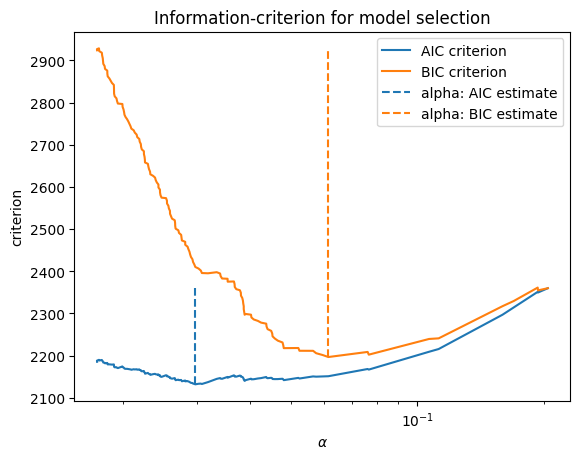

In [ ]:
## visualising
ax = results.plot()
ax.vlines(
    alpha_aic,
    results["AIC criterion"].min(),
    results["AIC criterion"].max(),
    label="alpha: AIC estimate",
    linestyles="--",
    color="tab:blue",
)
ax.vlines(
    alpha_bic,
    results["BIC criterion"].min(),
    results["BIC criterion"].max(),
    label="alpha: BIC estimate",
    linestyle="--",
    color="tab:orange",
)
ax.set_xlabel(r"$\alpha$")
ax.set_ylabel("criterion")
ax.set_xscale("log")
ax.legend()
_ = ax.set_title(
    f"Information-criterion for model selection")

In [ ]:
# First LASSO regression with the first alpha value
alpha_1 = 0.029660431722514865
lasso_1 = Lasso(alpha=alpha_1)
lasso_1.fit(X, Y)
non_zero_indices_1 = np.where(lasso_1.coef_ != 0)[0]

# Second LASSO regression with the second alpha value
alpha_2 = 0.061442809810681676
lasso_2 = Lasso(alpha=alpha_2)
lasso_2.fit(X, Y)
non_zero_indices_2 = np.where(lasso_2.coef_ != 0)[0]

# Find the intersection of non-zero indices from both runs
non_zero_indices_final = list(set(non_zero_indices_1) & set(non_zero_indices_2))

In [ ]:
## checking which vars made the cut
index_column_df = pd.DataFrame({'index': non_zero_indices_final,
                                'column_name': [X.columns[index] for index in non_zero_indices_final]})

## codebook merge
codebook2 = pd.merge (index_column_df, codebook, left_on = 'column_name', right_on='variable', how = 'left')

In [ ]:
display (codebook2[['variable', 'label']])

,variable,label
0,challengeID,NaN
1,n5e3,E3. Total income of household
2,m1i1,What is the highest grade/years of school that...
3,m1i3,What is the highest grade/years of school that...
4,m1i6,"What was BF doing most of last week (working, ..."
5,m4k2_12,What school/program attending: other type of t...
6,p5l5b,L5B. Is/Was this chosen public school . . . ?
7,hv5_ppvtss,PPVT standard score
8,hv5_wj9ss,Woodcock Johnson Test 9 standard score
9,hv5_wj10ss,Woodcock Johnson Test 10 standard score


In [ ]:
## subseting pre-clean df
target_columns = codebook2['column_name'].unique()
background9 = background7 [target_columns]

In [ ]:
## setting valid skips to NaNs in continuous vars
background10 = background9.copy()
for col in background10.columns:
    if col in continuous_cols or col in other_cols:
        background10[col] = background10[col].apply(lambda x: np.nan if x < 0 else x)

In [ ]:
## imputing again

## creating a copy of the original dataframe
background10_imp = background10.copy()

## creating imputers
mean_imputer = SimpleImputer(strategy='mean')
mode_imputer = SimpleImputer(strategy='most_frequent')
one_hot_encoder = OneHotEncoder()

for col in background10.columns:

    if col in continuous_cols:

        # Mean imputation
        background10_imp[col] = mean_imputer.fit_transform(background10[[col]])

    elif col in other_cols:

        # Mode imputation
        background10_imp[col] = mode_imputer.fit_transform(background10[[col]])

    elif col in categorical_cols:

        # One-hot encoding
        one_hot_df = pd.DataFrame(one_hot_encoder.fit_transform(background10[[col]]).toarray(),
                                  columns=[f"{col}_{cat}" for cat in one_hot_encoder.categories_[0]])
        background10_imp = pd.concat([background10_imp, one_hot_df], axis=1)
        background10_imp.drop(columns=[col], inplace=True)

## displaying sample of final df
display (background10_imp.sample (10))

,challengeID,n5e3,p5l5b,hv5_ppvtss,hv5_wj9ss,hv5_wj10ss,m4k13,m4l1,f3c41,f5j1,...,m5j1a_-1,m5j1a_1,m5j1a_2,m5j1a_3,m5j1a_4,m5j1a_5,m5j1a_6,m5j1a_7,m5j1a_8,m5j1a_9
143,144,42146.419243,101.0,92.985709,93.11373,97.965986,6422.332505,38689.340551,1.0,56570.859058,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1616,1617,42146.419243,3.0,120.000000,111.00000,122.000000,274.039847,0.000000,2.0,2014.046794,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2878,2879,42146.419243,101.0,75.000000,49.00000,77.000000,4306.975956,44803.838715,1.0,56570.859058,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1419,1420,42146.419243,101.0,112.000000,98.00000,103.000000,0.000000,38689.340551,6.0,44259.335338,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76,77,42146.419243,101.0,103.000000,100.00000,110.000000,21820.535305,33840.179077,1.0,56570.859058,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3152,3153,42146.419243,101.0,92.985709,93.11373,97.965986,932.452340,35620.571877,1.0,56570.859058,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
944,945,42146.419243,101.0,94.000000,100.00000,106.000000,10660.113688,71672.130280,1.0,56570.859058,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2132,2133,42146.419243,101.0,95.000000,86.00000,91.000000,0.000000,38689.340551,2.0,56570.859058,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
748,749,42146.419243,101.0,93.000000,115.00000,114.000000,1704.564146,16229.861875,2.0,69364.172733,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3292,3293,42146.419243,101.0,92.985709,93.11373,97.965986,0.000000,38689.340551,1.0,56570.859058,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
## merging with outcome
final_dat = pd.merge (background10_imp, outcomes[['challengeID', 'gpa']], on = 'challengeID')

### Feature visualisation

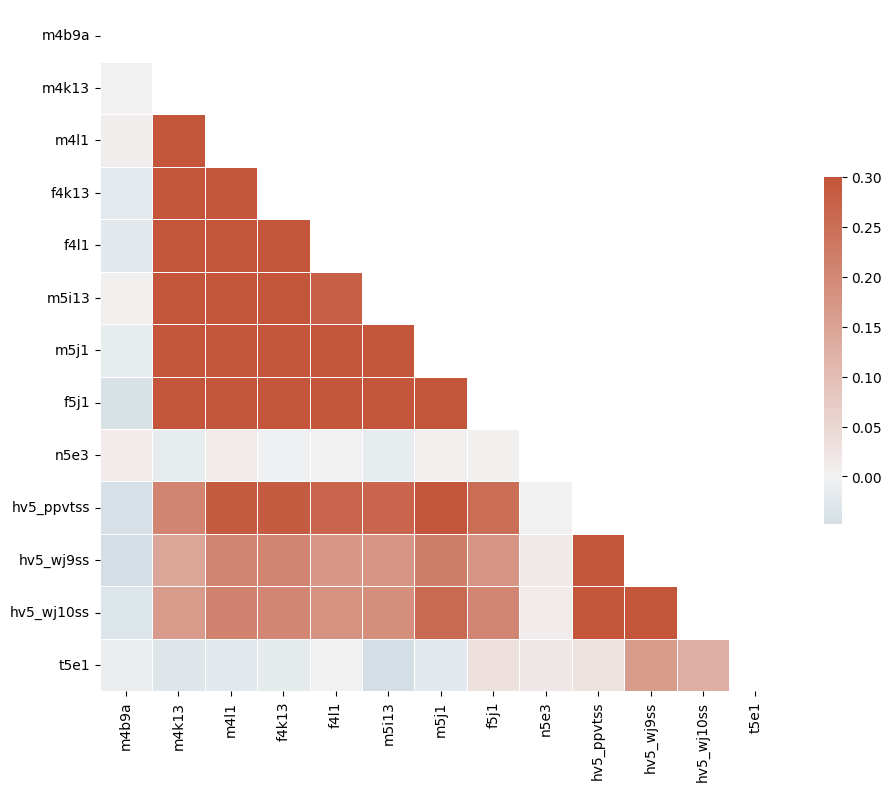

In [ ]:
## pairwise correlations for non-categorical vars
cont_cols = [col for col in continuous_variables if col in final_dat.columns]

# Compute the correlation matrix for the columns in cont_cols
corr = final_dat[cont_cols].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

### Upsampling

In [ ]:
## adding a household income level binary variable
final_dat2 = final_dat.copy()
final_dat2['income_level'] = ['low' if x <= 24250 else 'high' for x in final_dat2['n5e3']]

In [ ]:
final_dat2['income_level'].value_counts()

income_level
high    2109
low       12
Name: count, dtype: int64

In [ ]:
## bootstrapping

# Separate the data into two DataFrames based on the income level
df_high = final_dat2[final_dat2['income_level'] == 'high']
df_low = final_dat2[final_dat2['income_level'] == 'low']

# Bootstrap the high income level class
bootstrap_indices = np.random.choice(df_low.index, size=len(df_high), replace=True)
df_low_bootstrap = df_low.loc[bootstrap_indices]

# Concatenate the bootstrapped high income level class with the low income level class
final_dat3 = pd.concat([df_high, df_low_bootstrap])

In [ ]:
display (final_dat3)

,challengeID,n5e3,p5l5b,hv5_ppvtss,hv5_wj9ss,hv5_wj10ss,m4k13,m4l1,f3c41,f5j1,...,m5j1a_2,m5j1a_3,m5j1a_4,m5j1a_5,m5j1a_6,m5j1a_7,m5j1a_8,m5j1a_9,gpa,income_level
0,1,42146.419243,101.0,92.985709,93.11373,97.965986,6422.332505,38689.340551,1.0,56570.859058,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,high
1,3,42146.419243,101.0,92.985709,93.11373,97.965986,6422.332505,38689.340551,1.0,56570.859058,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,high
2,6,42146.419243,101.0,95.000000,107.00000,97.000000,0.000000,25973.763881,2.0,56570.859058,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,high
3,7,42146.419243,101.0,91.000000,92.00000,76.000000,0.000000,40005.390433,1.0,83280.114190,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.50,high
4,8,42146.419243,101.0,92.985709,93.11373,97.965986,0.000000,38689.340551,1.0,56570.859058,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,high
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1972,3894,6153.249599,101.0,96.000000,82.00000,95.000000,6422.332505,0.000000,1.0,29526.478733,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.75,low
1950,3849,14731.516877,101.0,79.000000,79.00000,69.000000,198.926053,38689.340551,2.0,17592.956184,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,low
918,1800,18366.284204,101.0,91.000000,97.00000,101.000000,6422.332505,38689.340551,1.0,56570.859058,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,low
1950,3849,14731.516877,101.0,79.000000,79.00000,69.000000,198.926053,38689.340551,2.0,17592.956184,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,low


In [ ]:
## adding imputed variable
final_dat4 = final_dat3.copy()
final_dat4['imputed'] = final_dat4['gpa'].notna().astype(int)
cols = final_dat4.columns.tolist()
cols = cols[:-2] + [cols[-1], cols[-2]]
final_dat5 = final_dat4[cols].copy()

In [ ]:
display (final_dat5)

,challengeID,n5e3,p5l5b,hv5_ppvtss,hv5_wj9ss,hv5_wj10ss,m4k13,m4l1,f3c41,f5j1,...,m5j1a_3,m5j1a_4,m5j1a_5,m5j1a_6,m5j1a_7,m5j1a_8,m5j1a_9,gpa,imputed,income_level
0,1,42146.419243,101.0,92.985709,93.11373,97.965986,6422.332505,38689.340551,1.0,56570.859058,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,high
1,3,42146.419243,101.0,92.985709,93.11373,97.965986,6422.332505,38689.340551,1.0,56570.859058,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,high
2,6,42146.419243,101.0,95.000000,107.00000,97.000000,0.000000,25973.763881,2.0,56570.859058,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,high
3,7,42146.419243,101.0,91.000000,92.00000,76.000000,0.000000,40005.390433,1.0,83280.114190,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.50,1,high
4,8,42146.419243,101.0,92.985709,93.11373,97.965986,0.000000,38689.340551,1.0,56570.859058,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,high
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1972,3894,6153.249599,101.0,96.000000,82.00000,95.000000,6422.332505,0.000000,1.0,29526.478733,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.75,1,low
1950,3849,14731.516877,101.0,79.000000,79.00000,69.000000,198.926053,38689.340551,2.0,17592.956184,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,low
918,1800,18366.284204,101.0,91.000000,97.00000,101.000000,6422.332505,38689.340551,1.0,56570.859058,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,low
1950,3849,14731.516877,101.0,79.000000,79.00000,69.000000,198.926053,38689.340551,2.0,17592.956184,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,low


In [ ]:
## imputing gpa

# initialising the IterativeImputer
imp = IterativeImputer ()

# Make a copy of the df
final_dat6 = final_dat5.copy()
final_dat6 = final_dat6.drop(['income_level', 'imputed'], axis=1)

# Perform the imputation on the entire DataFrame
final_dat7 = imp.fit_transform (final_dat6)

# Convert the result back to a DataFrame (it's returned as a numpy array)
final_dat7 = pd.DataFrame (final_dat7, columns=final_dat6.columns)

# Replace the 'gpa' column in the original DataFrame with the imputed 'gpa' column
final_dat6['gpa'] = final_dat7['gpa']

In [ ]:
display (final_dat6.sample(10))

,challengeID,n5e3,p5l5b,hv5_ppvtss,hv5_wj9ss,hv5_wj10ss,m4k13,m4l1,f3c41,f5j1,...,m5j1a_1,m5j1a_2,m5j1a_3,m5j1a_4,m5j1a_5,m5j1a_6,m5j1a_7,m5j1a_8,m5j1a_9,gpa
948,1859,10404.442872,101.0,91.000000,86.00000,78.000000,6422.332505,38689.340551,1.0,47643.236652,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.022132
598,1176,42146.419243,101.0,86.000000,91.00000,104.000000,32775.436973,33251.059983,1.0,30220.725553,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.794580
1773,3478,42146.419243,101.0,89.000000,98.00000,111.000000,6422.332505,38689.340551,1.0,56570.859058,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.250000
1950,3849,14731.516877,101.0,79.000000,79.00000,69.000000,198.926053,38689.340551,2.0,17592.956184,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.500000
2020,4008,42146.419243,101.0,60.000000,70.00000,80.000000,0.000000,13031.060337,2.0,56570.859058,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.250000
948,1859,10404.442872,101.0,91.000000,86.00000,78.000000,6422.332505,38689.340551,1.0,47643.236652,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.022132
2093,4179,15828.984275,101.0,79.000000,77.00000,83.000000,6422.332505,38689.340551,1.0,56570.859058,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.040752
1170,2322,45243.963216,101.0,83.000000,79.00000,66.000000,0.000000,12765.454254,1.0,56570.859058,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.000000
1253,2461,42146.419243,101.0,92.985709,93.11373,97.965986,0.000000,43815.978694,1.0,56570.859058,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.500000
2088,4168,42146.419243,101.0,97.000000,90.00000,94.000000,0.000000,52148.179342,6.0,94578.943008,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.075102


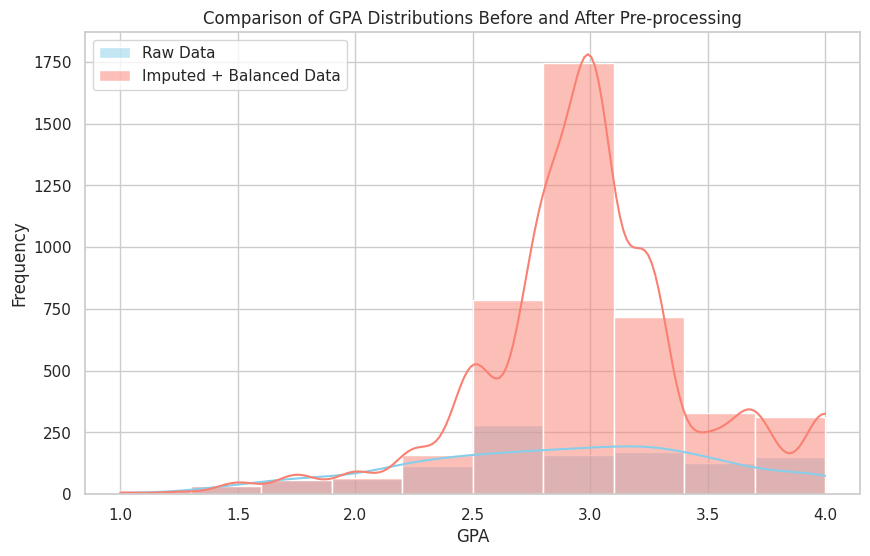

In [ ]:
## visualising GPA distribution before and after processing

# Plotting
sns.set(style = "whitegrid")
plt.figure (figsize=(10, 6))

outcomes2 = outcomes.copy()
outcomes2 = outcomes2.dropna (subset = ['gpa'])

# Plotting the distribution of GPA from df1
sns.histplot(outcomes2['gpa'], bins=10, kde=True, color='skyblue', label='Raw Data')

# Plotting the distribution of GPA from df2
sns.histplot(final_dat6['gpa'], bins=10, kde=True, color='salmon', label='Imputed + Balanced Data')

# Adding labels and title
plt.xlabel('GPA')
plt.ylabel('Frequency')
plt.title('Comparison of GPA Distributions Before and After Pre-processing')
plt.legend()

plt.show()

### Hyperparameter tuning

In [ ]:
display (final_dat5)

,challengeID,n5e3,p5l5b,hv5_ppvtss,hv5_wj9ss,hv5_wj10ss,m4k13,m4l1,f3c41,f5j1,...,m5j1a_3,m5j1a_4,m5j1a_5,m5j1a_6,m5j1a_7,m5j1a_8,m5j1a_9,gpa,imputed,income_level
0,1,42146.419243,101.0,92.985709,93.11373,97.965986,6422.332505,38689.340551,1.0,56570.859058,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.010195,0,high
1,3,42146.419243,101.0,92.985709,93.11373,97.965986,6422.332505,38689.340551,1.0,56570.859058,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.010195,0,high
2,6,42146.419243,101.0,95.000000,107.00000,97.000000,0.000000,25973.763881,2.0,56570.859058,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.010195,0,high
3,7,42146.419243,101.0,91.000000,92.00000,76.000000,0.000000,40005.390433,1.0,83280.114190,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.500000,1,high
4,8,42146.419243,101.0,92.985709,93.11373,97.965986,0.000000,38689.340551,1.0,56570.859058,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.010195,0,high
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1482,2898,31327.763900,101.0,93.000000,82.00000,80.000000,55.738931,9478.648061,5.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.010195,0,low
1950,3849,14731.516877,101.0,79.000000,79.00000,69.000000,198.926053,38689.340551,2.0,17592.956184,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.010195,0,low
1972,3894,6153.249599,101.0,96.000000,82.00000,95.000000,6422.332505,0.000000,1.0,29526.478733,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.750000,1,low
1950,3849,14731.516877,101.0,79.000000,79.00000,69.000000,198.926053,38689.340551,2.0,17592.956184,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.010195,0,low


In [ ]:
## encoding income_class
final_dat7 = pd.concat ([final_dat6, final_dat5[['income_level', 'imputed']]], axis = 1)
label_encoder = LabelEncoder()
final_dat7['income_level'] = label_encoder.fit_transform (final_dat7['income_level'])

In [ ]:
# print the classes in the order they map to the encoded values
print("Original value for 0: ", label_encoder.inverse_transform([0]))
print("Original value for 1: ", label_encoder.inverse_transform([1]))

Original value for 0:  ['high']
Original value for 1:  ['low']


In [ ]:
## test-train split
train_dat, test_dat = train_test_split (final_dat7, test_size = 0.3, random_state = 13)
train_x, train_y = train_dat.drop('gpa', axis=1), train_dat['gpa']
test_x, test_y = test_dat.drop('gpa', axis=1), test_dat['gpa']

In [ ]:
## random search for best RF hyperparameters
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})"
                  .format(results['mean_test_score'][candidate],
                          results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

# specify parameters and distributions to sample from
paramDist = {'n_estimators': list(range(10,2000)),
             'max_features': ['auto', 'sqrt'],
             'max_depth': list(range(1,10)) + [None],
             'min_samples_split': list(range(2,10)),
             'min_samples_leaf': list(range(1,10))}

# initialise classifier and random search object
rf = RandomForestRegressor (random_state = 0)
randomSearch = RandomizedSearchCV (rf, param_distributions = paramDist, n_iter = 10, cv = 5)

# fit random search object
randomSearch.fit(train_x, train_y)

# printing best parameters found
print ("Best parameters found:")
print (randomSearch.best_params_)

# best scores using provided utility function
report(randomSearch.cv_results_)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors

Best parameters found:
{'n_estimators': 878, 'min_samples_split': 5, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'max_depth': 9}
Model with rank: 1
Mean validation score: 0.455 (std: 0.018)
Parameters: {'n_estimators': 878, 'min_samples_split': 5, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'max_depth': 9}

Model with rank: 2
Mean validation score: 0.452 (std: 0.019)
Parameters: {'n_estimators': 641, 'min_samples_split': 7, 'min_samples_leaf': 6, 'max_features': 'auto', 'max_depth': 8}

Model with rank: 3
Mean validation score: 0.451 (std: 0.015)
Parameters: {'n_estimators': 1991, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 5}



### Running model

In [ ]:
## scaling
scaler = StandardScaler()
X_train_norm = scaler.fit_transform (train_x)
X_test_norm = scaler.transform (test_x)

In [ ]:
## initialisinh the regressor with the best parameters
regressor = RandomForestRegressor(n_estimators = 878,
                                  min_samples_split = 5,
                                  min_samples_leaf = 7,
                                  max_features = 'sqrt',
                                  max_depth = 9)

## fitting the model on the training data
regressor.fit (X_train_norm, train_y)

## performing 10-fold cross-validation and calculate the RMSE and R^2
rmse_scores = cross_val_score (regressor, X_test_norm, test_y, cv=10, scoring = make_scorer(lambda y, y_pred: sqrt(mean_squared_error(y, y_pred))))
r2_scores = cross_val_score (regressor, X_test_norm, test_y, cv=10, scoring='r2')

## printing the mean RMSE and R^2
print("Mean RMSE: ", rmse_scores.mean())
print("Adjusted R^2: ", r2_scores.mean())

Mean RMSE:  0.3756375484143929
Adjusted R^2:  0.4009173643996424


In [ ]:
## getting the MSE
0.3756375484143929 * 0.3756375484143929

0.14110356777877536

In [ ]:
# Define the model as a function that always predicts the mean of y
class MeanPredictor(BaseEstimator):
    def fit(self, X, y):
        self.mean = np.mean(y)
        return self
    def predict(self, X):
        return np.full(X.shape[0], self.mean)

# data
dat_x, dat_y = datClean (codebook, background4, outcomes, 'gpa', split = False)

# Initialize the model
model = MeanPredictor()

# Perform 10-fold cross validation and calculate negative mean squared error
scores = cross_val_score (model, dat_x, dat_y, cv=10, scoring='neg_mean_squared_error')

# Calculate mean RMSE
mean_rmse = np.sqrt(-np.mean(scores))

print(f"10-fold cross validation mean RMSE: {mean_rmse}")

10-fold cross validation mean RMSE: 0.6654111669924441


In [ ]:
## getting the MSE
0.6654111669924441 ** 2

0.44277202115824627

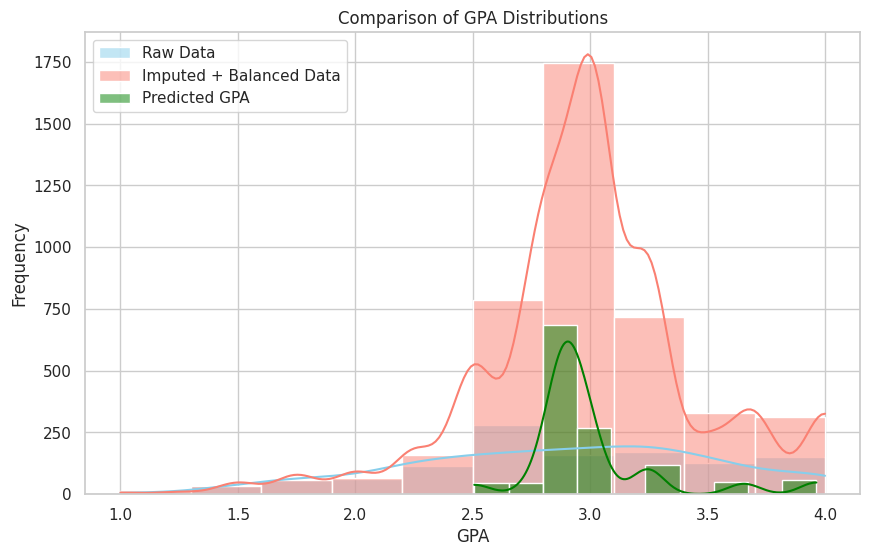

In [ ]:
## adding GPA pred distribution
regressor = RandomForestRegressor(n_estimators = 878,
                                  min_samples_split = 5,
                                  min_samples_leaf = 7,
                                  max_features = 'sqrt',
                                  max_depth = 9)

# Plotting
sns.set(style = "whitegrid")
plt.figure (figsize=(10, 6))

outcomes2 = outcomes.copy()
outcomes2 = outcomes2.dropna (subset = ['gpa'])

# getting predictions
regressor.fit (X_train_norm, train_y)
y_pred = regressor.predict(X_test_norm)

# Plotting the distribution of GPA from df1
sns.histplot(outcomes2['gpa'], bins=10, kde=True, color='skyblue', label='Raw Data')

# Plotting the distribution of GPA from df2
sns.histplot(final_dat6['gpa'], bins=10, kde=True, color='salmon', label='Imputed + Balanced Data')

# plotting predicted GPA
sns.histplot(y_pred, bins=10, kde=True, color='green', label='Predicted GPA')

# Adding labels and title
plt.xlabel('GPA')
plt.ylabel('Frequency')
plt.title('Comparison of GPA Distributions')
plt.legend()

plt.show()

### Diagnostics

#### Model without imputed values

In [ ]:
display (final_dat7)

,challengeID,n5e3,p5l5b,hv5_ppvtss,hv5_wj9ss,hv5_wj10ss,m4k13,m4l1,f3c41,f5j1,...,m5j1a_3,m5j1a_4,m5j1a_5,m5j1a_6,m5j1a_7,m5j1a_8,m5j1a_9,gpa,income_level,imputed
0,1,42146.419243,101.0,92.985709,93.11373,97.965986,6422.332505,38689.340551,1.0,56570.859058,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.018875,0,0
1,3,42146.419243,101.0,92.985709,93.11373,97.965986,6422.332505,38689.340551,1.0,56570.859058,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.946433,0,0
2,6,42146.419243,101.0,95.000000,107.00000,97.000000,0.000000,25973.763881,2.0,56570.859058,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.026924,0,0
3,7,42146.419243,101.0,91.000000,92.00000,76.000000,0.000000,40005.390433,1.0,83280.114190,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.500000,0,1
4,8,42146.419243,101.0,92.985709,93.11373,97.965986,0.000000,38689.340551,1.0,56570.859058,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.101939,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1909,3769,17892.196189,101.0,107.000000,96.00000,91.000000,6422.332505,38689.340551,1.0,56570.859058,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.500000,1,1
43,79,22776.084414,101.0,92.985709,93.11373,97.965986,6422.332505,38689.340551,1.0,56570.859058,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.873228,1,0
1538,3015,16620.380661,101.0,94.000000,92.00000,97.000000,2442.942038,13831.392281,1.0,56570.859058,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.250000,1,1
1909,3769,17892.196189,101.0,107.000000,96.00000,91.000000,6422.332505,38689.340551,1.0,56570.859058,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.500000,1,1


In [ ]:
## getting data
final_dat_noImpute = final_dat7[final_dat7['imputed']== 1]

## test-train split
train_dat3, test_dat3 = train_test_split (final_dat_noImpute, test_size = 0.3, random_state = 13)
train_x3, train_y3 = train_dat3.drop('gpa', axis=1), train_dat3['gpa']
test_x3, test_y3 = test_dat3.drop('gpa', axis=1), test_dat3['gpa']

## scaling
scaler = StandardScaler()
X_train_norm3 = scaler.fit_transform (train_x3)
X_test_norm3 = scaler.transform (test_x3)

In [ ]:
## initialisinh the regressor with the best parameters
regressor3 = RandomForestRegressor(n_estimators = 878,
                                  min_samples_split = 5,
                                  min_samples_leaf = 7,
                                  max_features = 'sqrt',
                                  max_depth = 9)

## fitting the model on the training data
regressor3.fit (X_train_norm3, train_y3)

## performing 10-fold cross-validation and calculate the RMSE and R^2
rmse_scores3 = cross_val_score (regressor3, X_test_norm3, test_y3, cv=10, scoring=make_scorer(lambda y, y_pred: sqrt(mean_squared_error(y, y_pred))))
r2_scores3 = cross_val_score (regressor3, X_test_norm3, test_y3, cv=10, scoring='r2')

## printing the mean RMSE and R^2
print("Mean RMSE: ", rmse_scores3.mean())
print("Adjusted R^2: ", r2_scores3.mean())

Mean RMSE:  0.39306584076004814
Adjusted R^2:  0.16752552534587234


#### Model without bootstrapped values

In [ ]:
## getting data
final_dat_noBoot = final_dat7[final_dat7['challengeID'].isin(final_dat2['challengeID'])]

## test-train split
train_dat2, test_dat2 = train_test_split (final_dat_noBoot, test_size = 0.3, random_state = 13)
train_x2, train_y2 = train_dat2.drop('gpa', axis=1), train_dat2['gpa']
test_x2, test_y2 = test_dat2.drop('gpa', axis=1), test_dat2['gpa']

## scaling
scaler = StandardScaler()
X_train_norm2 = scaler.fit_transform (train_x2)
X_test_norm2 = scaler.transform (test_x2)

In [ ]:
## initialisinh the regressor with the best parameters
regressor2 = RandomForestRegressor(n_estimators = 878,
                                  min_samples_split = 5,
                                  min_samples_leaf = 7,
                                  max_features = 'sqrt',
                                  max_depth = 9)

## fitting the model on the training data
regressor2.fit (X_train_norm2, train_y2)

## performing 10-fold cross-validation and calculate the RMSE and R^2
rmse_scores2 = cross_val_score (regressor2, X_test_norm2, test_y2, cv=10, scoring=make_scorer(lambda y, y_pred: sqrt(mean_squared_error(y, y_pred))))
r2_scores2 = cross_val_score (regressor2, X_test_norm2, test_y2, cv=10, scoring='r2')

## printing the mean RMSE and R^2
print("Mean RMSE: ", rmse_scores2.mean())
print("Adjusted R^2: ", r2_scores2.mean())

Mean RMSE:  0.3910784572384147
Adjusted R^2:  0.377905364116188


#### Results from holdout set

In [ ]:
final_dat_wHoldout = pd.merge (background10_imp, holdout[['challengeID', 'gpa']], on = 'challengeID')

In [ ]:
final_dat_wHoldout['imputed'] = final_dat_wHoldout['gpa'].notna().astype(int)

In [ ]:
final_dat_wHoldout['income_level'] = ['low' if x <= 24250 else 'high' for x in final_dat_wHoldout['n5e3']]

In [ ]:
## initialising the IterativeImputer
imp = IterativeImputer ()

# Make a copy of the df
final_dat_wHoldout2 = final_dat_wHoldout.copy()
final_dat_wHoldout2 = final_dat_wHoldout2.drop(['income_level', 'imputed'], axis=1)

# Perform the imputation on the entire DataFrame
final_dat_wHoldout3 = imp.fit_transform (final_dat_wHoldout2)

# Convert the result back to a DataFrame (it's returned as a numpy array)
final_dat_wHoldout3 = pd.DataFrame (final_dat_wHoldout3, columns = final_dat_wHoldout2.columns)

# Replace the 'gpa' column in the original DataFrame with the imputed 'gpa' column
final_dat_wHoldout2['gpa'] = final_dat_wHoldout3['gpa']

In [ ]:
## encoding income_class
final_dat_wHoldout4 = pd.concat ([final_dat_wHoldout2, final_dat_wHoldout[['income_level', 'imputed']]], axis = 1)
label_encoder = LabelEncoder()
final_dat_wHoldout4['income_level'] = label_encoder.fit_transform (final_dat_wHoldout4['income_level'])

In [ ]:
## split
holdout_x, holdout_y = final_dat_wHoldout4.drop ('gpa', axis = 1), final_dat_wHoldout4['gpa']

In [ ]:
## scaling
scaler = StandardScaler()
holdout_x_norm = scaler.fit_transform (holdout_x)

In [ ]:
## initialisinh the regressor with the best parameters
regressor4 = RandomForestRegressor(n_estimators = 878,
                                  min_samples_split = 5,
                                  min_samples_leaf = 7,
                                  max_features = 'sqrt',
                                  max_depth = 9)

## fitting the model on the training data
regressor4.fit (X_train_norm, train_y)

## performing 10-fold cross-validation and calculate the RMSE and R^2
rmse_scores4 = cross_val_score (regressor4, holdout_x_norm, holdout_y, cv=10, scoring=make_scorer(lambda y, y_pred: sqrt(mean_squared_error(y, y_pred))))
r2_scores4 = cross_val_score (regressor4, holdout_x_norm, holdout_y, cv=10, scoring='r2')

## printing the mean RMSE and R^2
print("Mean RMSE: ", rmse_scores4.mean())
print("Adjusted R^2: ", r2_scores4.mean())

Mean RMSE:  0.4538867674604511
Adjusted R^2:  0.1458604881529857


In [ ]:
0.3756375484143929 ** 2

0.14110356777877536

In [ ]:
0.4538867674604511 ** 2

0.2060131976756976

In [ ]:
## data without imputed values
final_dat_wHoldout5 = final_dat_wHoldout4.copy()
final_dat_wHoldout5 = final_dat_wHoldout5[final_dat_wHoldout5['imputed'] == 1]

In [ ]:
## split
holdout_x2, holdout_y2 = final_dat_wHoldout5.drop ('gpa', axis = 1), final_dat_wHoldout5['gpa']

## scaling
scaler = StandardScaler()
holdout_x2_norm = scaler.fit_transform (holdout_x2)

## initialisinh the regressor with the best parameters
regressor5 = RandomForestRegressor(n_estimators = 878,
                                  min_samples_split = 5,
                                  min_samples_leaf = 7,
                                  max_features = 'sqrt',
                                  max_depth = 9)

## fitting the model on the training data
regressor5.fit (X_train_norm, train_y)

## performing 10-fold cross-validation and calculate the RMSE and R^2
rmse_scores5 = cross_val_score (regressor5, holdout_x2_norm, holdout_y2, cv=10, scoring=make_scorer(lambda y, y_pred: sqrt(mean_squared_error(y, y_pred))))
r2_scores5 = cross_val_score (regressor5, holdout_x2_norm, holdout_y2, cv=10, scoring='r2')

## printing the mean RMSE and R^2
print("Mean RMSE: ", rmse_scores5.mean())
print("Adjusted R^2: ", r2_scores5.mean())

Mean RMSE:  0.6043540135620529
Adjusted R^2:  0.11545944494003191


In [ ]:
0.6043540135620529 ** 2

0.365243773708562

## Model Interpretability

### Feature Importance with MDI

In [ ]:
X_train_norm = scaler.fit_transform (train_x)

## initialisinh the regressor with the best parameters
regressor = RandomForestRegressor(n_estimators = 878,
                                  min_samples_split = 5,
                                  min_samples_leaf = 7,
                                  max_features = 'sqrt',
                                  max_depth = 9)

## fitting the model on the training data
regressor.fit (X_train_norm, train_y)

RandomForestRegressor(max_depth=9, max_features='sqrt', min_samples_leaf=7,
                      min_samples_split=5, n_estimators=878)

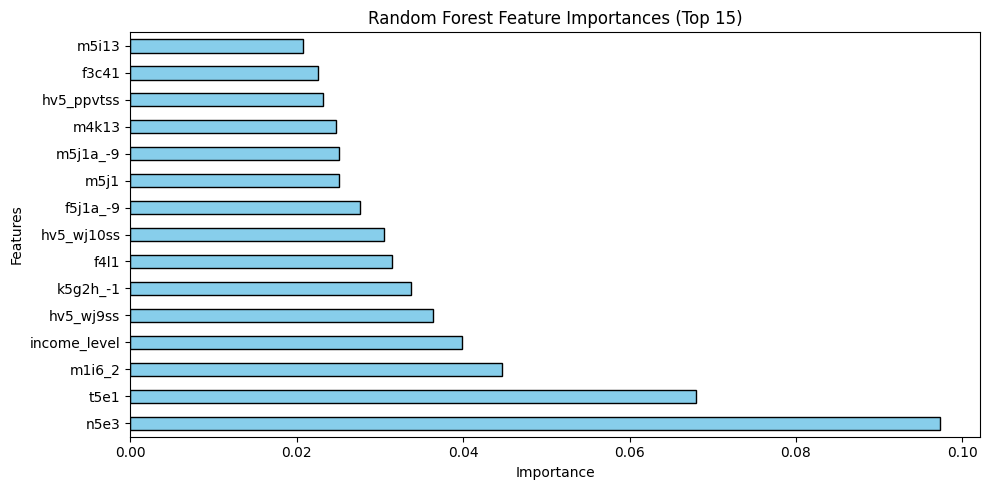

In [ ]:
# Mean decrease in impurity

# Instantiate storage list
feature_importances = []

# Iterating over each tree in the random forest
for tree in regressor.estimators_:
    importances = tree.feature_importances_
    feature_importances.append(importances)

# Converting list of feature importances into a DataFrame
feature_importances_df = pd.DataFrame(feature_importances, columns=train_x.columns)

# Computing mean decrease in impurity (MDI) by taking mean of feature importances
mdi_importances = feature_importances_df.mean().sort_values(ascending=False)

# Selecting top 15 most important features
top_15_features = mdi_importances[:15]

# Creating a new figure with a specified size
plt.figure(figsize=(10, 5))

# Plotting top 15 feature importances
ax = top_15_features.plot.barh(color='skyblue', edgecolor='black')

# Setting title and labels
ax.set_title("Random Forest Feature Importances (Top 15)", fontsize=12)
ax.set_xlabel("Importance", fontsize=10)
ax.set_ylabel("Features", fontsize=10)

# Setting layout for better visualization
plt.tight_layout()
plt.show()


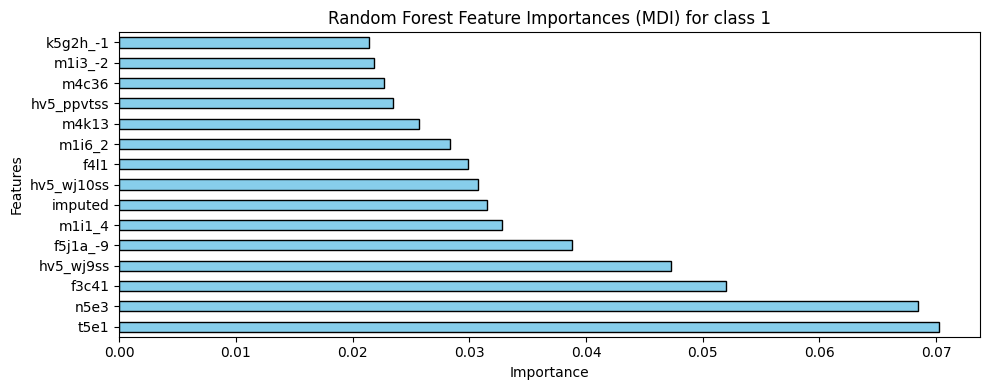

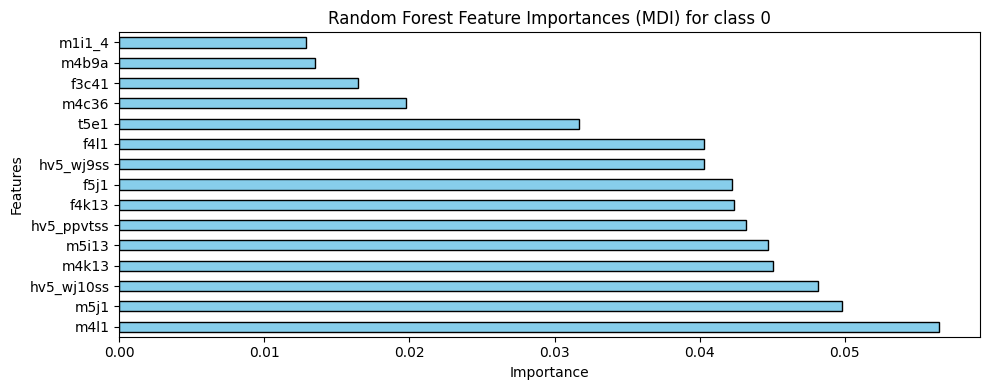

In [ ]:
## values for income classes
classes = train_x['income_level'].unique()

## regressor
rf2 = RandomForestRegressor(n_estimators = 878,
                            min_samples_split = 5,
                            min_samples_leaf = 7,
                            max_features = 'sqrt',
                            max_depth = 9)

## iterating through income classes
for class_ in classes:

    # Filter the data for the current class
    train_x_class = train_x[train_x['income_level'] == class_]
    train_y_class = train_y[train_x['income_level'] == class_]

    scaler2 = StandardScaler()
    norm_train_x_class = scaler2.fit_transform(train_x_class)

    # Fit the model on the data for the current class
    rf2.fit(norm_train_x_class, train_y_class)

    # Compute the feature importances
    feature_importances = []
    for tree in rf2.estimators_:
        importances = tree.feature_importances_
        feature_importances.append(importances)

    feature_importances_df = pd.DataFrame(feature_importances, columns=train_x.columns)
    mdi_importances = feature_importances_df.mean().sort_values(ascending=False)[:15]  # Select top 15 features

    # Plot the feature importances
    plt.figure(figsize=(10,4))  # Adjusted figure size
    ax = mdi_importances.plot.barh(color='skyblue', edgecolor='black')
    ax.set_title(f"Random Forest Feature Importances (MDI) for class {class_}", fontsize=12)
    ax.set_xlabel("Importance", fontsize=10)
    ax.set_ylabel("Features", fontsize=10)
    plt.tight_layout()
    plt.show()

### SHAP values

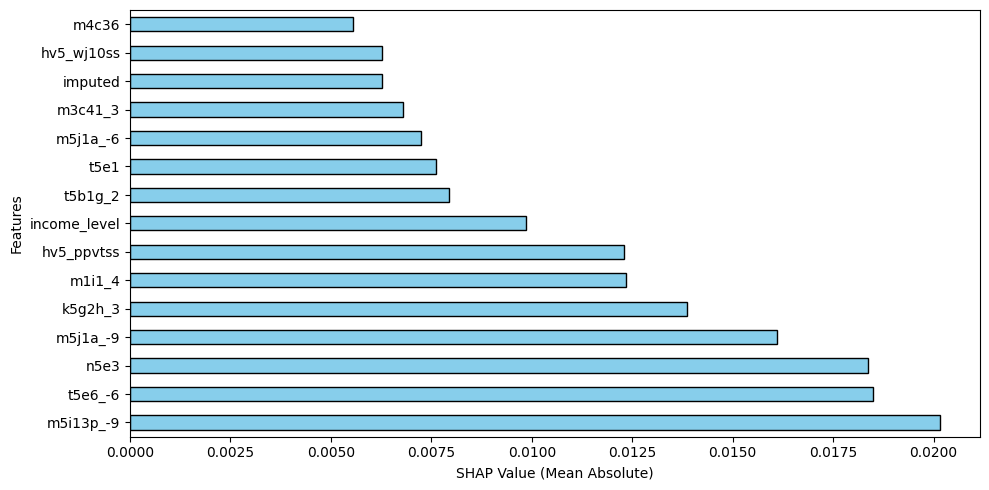

In [ ]:
## regressor
rf2 = RandomForestRegressor(n_estimators = 878,
                            min_samples_split = 5,
                            min_samples_leaf = 7,
                            max_features = 'sqrt',
                            max_depth = 9)


scaler2 = StandardScaler()
norm_train_x = scaler2.fit_transform (train_x)

# Fit the model on the data for the current class
rf2.fit(norm_train_x, train_y)

# Compute the SHAP values
explainer = shap.TreeExplainer(rf2)
shap_values = explainer.shap_values(norm_train_x)

# Compute the mean absolute SHAP values for each feature
mean_shap_values = np.abs(shap_values).mean(axis=0)
mean_shap_values_series = pd.Series(mean_shap_values, index=train_x.columns).sort_values(ascending=False)[:15]

# Plot the SHAP values
plt.figure(figsize=(10, 5))
ax = mean_shap_values_series.plot.barh(color='skyblue', edgecolor='black')
ax.set_xlabel("SHAP Value (Mean Absolute)", fontsize=10)
ax.set_ylabel("Features", fontsize=10)
plt.tight_layout()
plt.show()

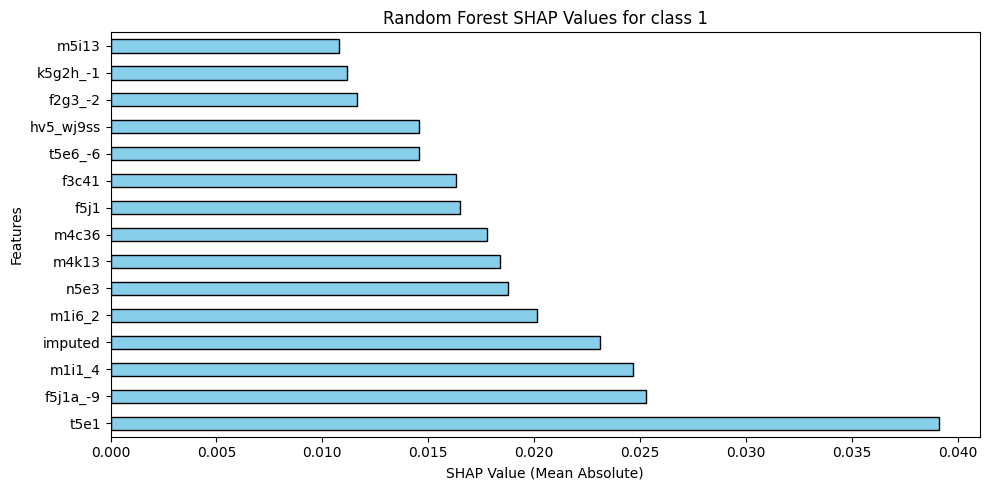

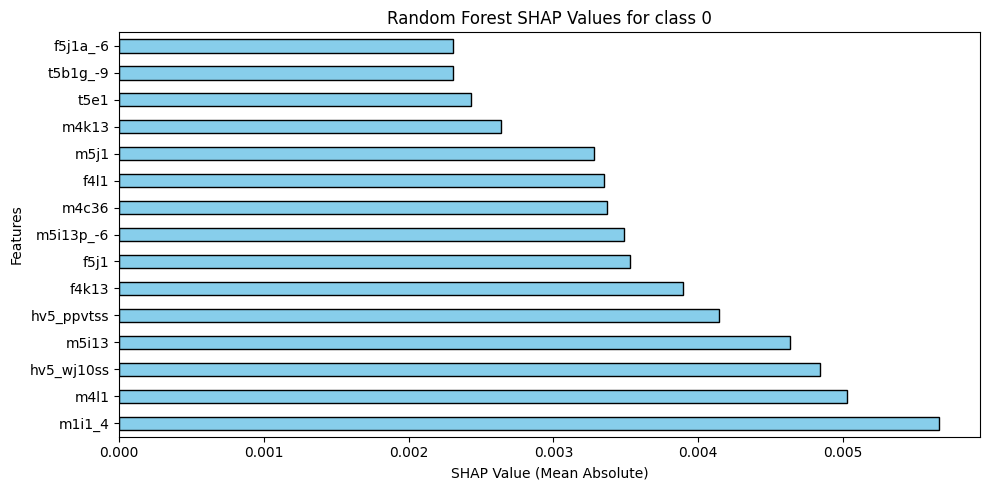

In [ ]:
# regressor
rf3 = RandomForestRegressor(n_estimators = 878,
                            min_samples_split = 5,
                            min_samples_leaf = 7,
                            max_features = 'sqrt',
                            max_depth = 9)

# iterating through income classes
for class_ in classes:

    # Filter the data for the current class
    train_x_class = train_x[train_x['income_level'] == class_]
    train_y_class = train_y[train_x['income_level'] == class_]

    scaler3 = StandardScaler()
    norm_train_x_class = scaler3.fit_transform(train_x_class)

    # Fit the model on the data for the current class
    rf3.fit(norm_train_x_class, train_y_class)

    # Compute the SHAP values
    explainer = shap.TreeExplainer(rf3)
    shap_values = explainer.shap_values(norm_train_x_class)

    # Compute the mean absolute SHAP values for each feature
    mean_shap_values = np.abs(shap_values).mean(axis=0)
    mean_shap_values_series = pd.Series(mean_shap_values, index=train_x_class.columns).sort_values(ascending=False)[:15]

    # Plot the SHAP values
    plt.figure(figsize=(10, 5))
    ax = mean_shap_values_series.plot.barh(color='skyblue', edgecolor='black')
    ax.set_title(f"Random Forest SHAP Values for class {class_}", fontsize=12)
    ax.set_xlabel("SHAP Value (Mean Absolute)", fontsize=10)
    ax.set_ylabel("Features", fontsize=10)
    plt.tight_layout()
    plt.show()

### LIME

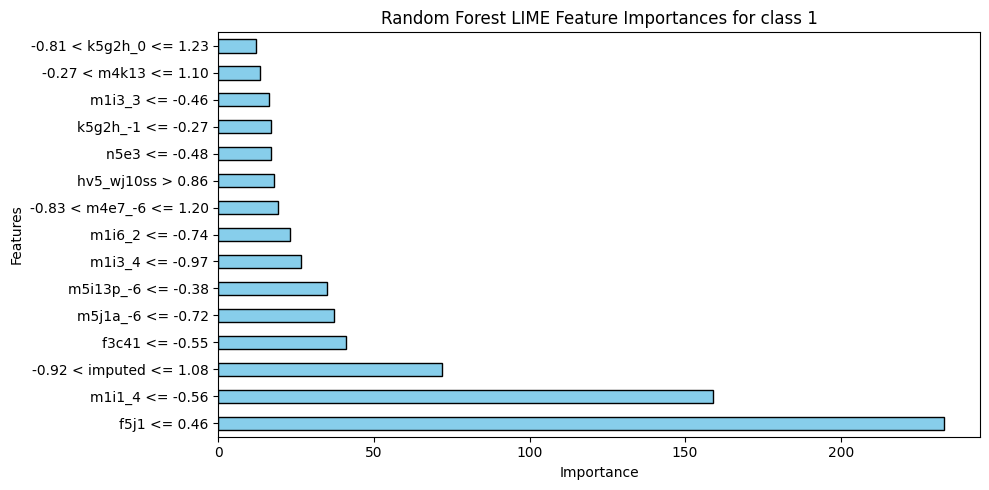

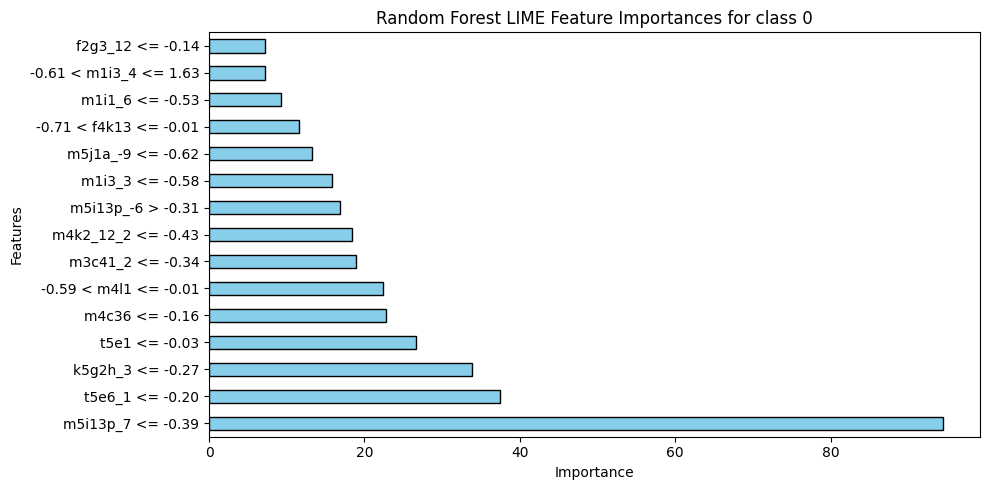

In [ ]:
# regressor
rf4 = RandomForestRegressor(n_estimators=4,
                             min_samples_split=5,
                             min_samples_leaf=7,
                             max_features='sqrt',
                             max_depth=9)

# iterating through income classes
for class_ in classes:

    # Filter the data for the current class
    train_x_class = train_x[train_x['income_level'] == class_]
    train_y_class = train_y[train_x['income_level'] == class_]

    scaler4 = StandardScaler()
    norm_train_x_class = scaler4.fit_transform(train_x_class)

    # Fit the model on the data for the current class
    rf4.fit(norm_train_x_class, train_y_class)

    # Initialize LimeTabularExplainer
    explainer = LimeTabularExplainer(norm_train_x_class, mode="regression", feature_names=train_x_class.columns)

    # Get feature importances using LIME
    feature_importances = []
    for i in range(norm_train_x_class.shape[0]):
        exp = explainer.explain_instance(norm_train_x_class[i], rf4.predict, num_features=len(train_x_class.columns))
        lime_importance = dict(exp.as_list())
        feature_importances.append(lime_importance)

    # Convert to DataFrame
    lime_importances_df = pd.DataFrame(feature_importances).sum().sort_values(ascending=False)

    # Select top 15 features
    top_15_features = lime_importances_df[:15]

    # Plot the LIME feature importances
    plt.figure(figsize=(10, 5))
    ax = top_15_features.plot.barh(color='skyblue', edgecolor='black')
    ax.set_title(f"Random Forest LIME Feature Importances for class {class_}", fontsize=12)
    ax.set_xlabel("Importance", fontsize=10)
    ax.set_ylabel("Features", fontsize=10)
    plt.tight_layout()
    plt.show()